# Trump Detector - Naive Methode

### Ein CNN, welches Karikaturen bzw. Cartoons von politischen Persönlichkeiten zu einem Model zusammenfasst. Dieses Modell wird darauf trainiert Donald Trump in einer farbigen Karikatur zu finden.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D, Dropout,Flatten, MaxPooling2D
import tensorflow.keras.models as models
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import SGD, Adam
from PIL import ImageDraw

In [2]:
filename = "trump_caricature_detector.h5"
path = "images"
test_img_path = "test_images"
result_img_path ="result_images"

#### In diesem Pfad sind die Gesichter bzw. Karikaturen verschwiedener politischer Personen. Jede Person hat einen eigenen gleichnamigen Ordner.

In [3]:
car_names = os.listdir(path)
print(car_names)

['abraham_lincoln', 'Angela_Merkel', 'Arnold_Schwarzenegger', 'Barak_Obama', 'Bill_Clinton', 'Bill_Gates', 'dalai_lama', 'Donald_Trump', 'George_Bush', 'Hiliary_Clinton', 'Joe_Biden', 'john_F_kennedy', 'Kim_Jong-un', 'Mark_Zuckerberg', 'mother_teresa', 'nelson_mandela', 'osama_bin_laden', 'Ronald_Reagan', 'steve_jobs', 'Vladimir_Putin', 'Warren_Buffett', 'Xi_Jinping']


In [4]:
#im car_names array steht Donald Trump an 8. Stelle
# gezählt von 0 ...7
DONALD = 7

#### In diesem Ordner liegen die Karikaturen, an denen der fertige Trump-Detector getestet werden soll

In [5]:
test_img_array = os.listdir(test_img_path)
print(test_img_array)

['test_1.jpg', 'test_2.jpg', 'test_3.jpg', 'test_4.jpg']


## Konvertiere alle Bilder zu Quadraten

#### Da sich die Gesichter durch kleine aber markante Details unterscheiden, habe ich mich für eine Auflösung von 128px entschieden. Alles darunter würde die Eigenschaften verzerren. Alles darüber verlangsamt die Verarbeitung auf der CPU zu stark.

In [6]:
for names in car_names:
    cpath = os.path.join(path, names)
    for img in os.listdir(cpath):
        
        img_path = os.path.join(cpath, img)
        im = Image.open(img_path)
        
        sqrWidth = np.ceil(np.sqrt(im.size[0]*im.size[1])).astype(int)
        im_resize = im.resize((sqrWidth, sqrWidth))
        
        #delete old image
        os.remove(img_path)
        
        im_resize = im_resize.resize((128, 128))
        im_resize.save(img_path)
        

## Transform Dataset to Train/Test

#### Hier werden die Bilder und ihre Identitäten so aufgeteilt, dass sie in einem Train/Test-Verfahren verwendet werden können

In [7]:
data = []
label = []
label_val = 0

for names in car_names:
    cpath = os.path.join(path, names)
    for img in os.listdir(cpath):
        image_array = cv2.imread(os.path.join(cpath, img))
        #wenn hier fehler auftaucht
        #dann wahrsch. weil Dateiname zu lang
        image_array2 = cv2.cvtColor(image_array, cv2.COLOR_RGB2BGR)
        data.append(image_array2)
        label.append([label_val])  
    label_val+= 1

In [8]:
data = np.asarray(data)
label = np.asarray(label)

In [9]:
#print(label)

### Test Image split

In [10]:
#70% train, 30% test
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.3)

In [11]:
X_train[0].shape

(128, 128, 3)

In [12]:
y_train[0].shape

(1,)

[2]


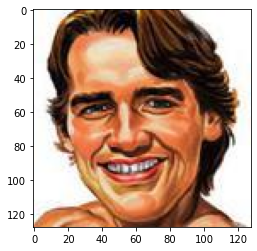

In [13]:
print(y_train[1])
plt.imshow(X_train[1])
plt.show()

In [14]:
print(car_names[int(y_train[1])])

Arnold_Schwarzenegger


## The Model - Trump oder nicht Trump - Ja/Nein Modell

In [15]:
X_train = X_train.astype(np.float64) 
X_test = X_test.astype(np.float64)

In [16]:
X_train.shape

(436, 128, 128, 3)

In [17]:
y_train.shape

(436, 1)

In [18]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), input_shape=(128, 128, 3), activation="relu"))
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation="relu"))
model.add(Conv2D(64, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 58, 58, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 29, 64)        0

#### Zusätzliche Daten generieren

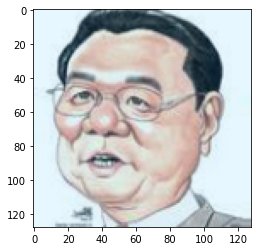

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

gen = ImageDataGenerator(
    width_shift_range=3, 
    height_shift_range=3, 
    zoom_range=0.1, 
    horizontal_flip=True,
    featurewise_center=True,
    featurewise_std_normalization=True)

gen.fit(X_train)
for batch in gen.flow(X_train, y_train, shuffle=False):
    # print(batch[0].shape)
    # print(batch[1])
    
    first_image = batch[0][0]
    plt.imshow((first_image - first_image.min()) / (first_image.max() - first_image.min()))
    plt.show()
    break

#### Model trainieren

In [21]:
#Dies ist das "Lösungsarray"
#Das Model wird hier getestet, ob es alle Antworten richtig hat bzw. ob es D:Trump erkennt oder nicht

y_train_trump = y_train == DONALD
#print(y_train_trump)

In [22]:
gen = ImageDataGenerator(width_shift_range=3, height_shift_range=3, zoom_range=0.1, horizontal_flip=True)

# training MIT generierten Bildern
history = model.fit_generator(
    gen.flow(X_train, y_train_trump, batch_size=10, shuffle=True),
    validation_data=(X_test,y_test), 
    epochs=20)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
44/44 [==============================] - 21s 473ms/step - loss: 59.8427 - accuracy: 0.7661 - val_loss: 3.3349 - val_accuracy: 0.0428
Epoch 2/20
44/44 [==============================] - 20s 460ms/step - loss: 5.3399 - accuracy: 0.7477 - val_loss: 18.0846 - val_accuracy: 0.0374
Epoch 3/20
44/44 [==============================] - 20s 456ms/step - loss: 2.3969 - accuracy: 0.8257 - val_loss: 42.0450 - val_accuracy: 0.0374
Epoch 4/20
44/44 [==============================] - 22s 504ms/step - loss: 2.1687 - accuracy: 0.8142 - val_loss: 172.4705 - val_accuracy: 0.0481
Epoch 5/20
44/44 [==============================] - 21s 469ms/step - loss: 1.5671 - accuracy: 0.8555 - val_loss: 41.7803 - val_accuracy: 0.0535
Epoch 6/20
44/44 [==============================] - 20s 459ms/step - loss: 0.7121 - accuracy: 0.8578 - val_loss: 81.1491 - val_accuracy: 0.0428
Epoch 7/20
44/44 [==============================] - 20s 465

In [23]:
# training ohne generierte Bilder
#model.fit(X_train, y_train_trump, batch_size=128, epochs=10, shuffle=True)

#### History

In [24]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

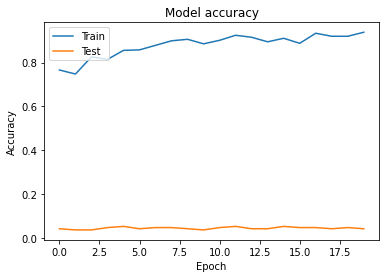

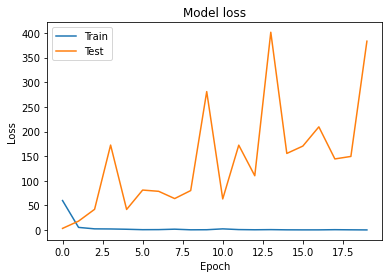

In [25]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#### Model evaluieren

In [26]:
y_test_trump = y_test == DONALD

In [27]:
print(model.evaluate(X_train, y_train_trump))

14/14 [==============================] - 3s 228ms/step - loss: 0.1732 - accuracy: 0.9679
[0.17316175997257233, 0.9678899049758911]


In [28]:
print(model.evaluate(X_test, y_test_trump))

6/6 [==============================] - 1s 207ms/step - loss: 0.6359 - accuracy: 0.8930
[0.6358565092086792, 0.893048107624054]


In [29]:
model.save(filename)

# Model anwenden

In [30]:
model = models.load_model(filename)

#### Sliding Window Verfahren

In [31]:
size = 100
step_size = 10

In [35]:
def sliding_window(size, step_size, img, image):
    cars = [] 

    for x in range(0, img.size[0] - size, step_size):
        for y in range(0, img.size[1] - size, step_size):
            part = img.crop((x, y, x + size, y + size))
            data = np.asarray(part.resize((128, 128), resample=Image.BICUBIC))
            data = data.astype(np.float64)

            pred = model.predict(data.reshape(-1, 128, 128, 3))
            if pred[0][0] > 0.99:
                print(pred[0][0])
                cars.append((x, y))

    out = img.copy()
    draw = ImageDraw.Draw(out)

    cars_drawn = []

    for car in cars:
        exists = False
        for car_drawn in cars_drawn:
            if car[0] >= car_drawn[0] and car[0] <= car_drawn[0] + size:
                if car[1] >= car_drawn[1] and car[1] <= car_drawn[1] + size:
                    exists = True

        if exists == False:
            points = [
                car,
                (car[0], car[1] + size),
                (car[0] + size, car[1] + size),
                (car[0] + size, car[1]),
                car
            ]
            draw.line(points, "yellow", 5)
            cars_drawn.append(car)
            print(car)
            
    out = out.save(os.path.join(result_img_path, image)) 


In [36]:
for image in test_img_array:
    #test_img_path
    img = Image.open(os.path.join(test_img_path, image))
    #img = img.resize((round(img.size[0] / 2), round(img.size[1] / 2)), resample=Image.BICUBIC)
    sliding_window(size, step_size, img, image)

0.99741817
0.99999774
0.99868006
0.9999702
0.9990933
0.99999523
0.99999774
0.99364835
1.0
0.9999963
0.9970253
0.9999764
0.999959
0.99998975
0.9967943
1.0
1.0
0.9995427
0.99735343
0.99980396
0.99583215
0.999984
0.99888974
0.9903633
0.9996182
0.998725
0.99998534
0.99523926
0.9981704
0.99787533
0.99824774
0.9998894
0.99999475
0.9999641
0.9998698
0.99958104
0.99995434
0.9999988
0.9999609
1.0
(10, 120)
(40, 20)
(90, 10)
(220, 40)
(230, 210)
(330, 70)
(350, 0)
0.99499255
0.9901097
0.99727076
0.9999286
0.99756026
0.990101
0.9996425
0.9999324
(10, 150)
(170, 90)
1.0
1.0
1.0
0.99029446
1.0
0.9998683
0.99969256
0.9974407
0.9955206
(10, 30)
(30, 0)
0.9969213
0.99530953
0.9964478
0.99950325
0.9994326
0.9995153
0.99173087
0.9950486
0.99606895
0.99991894
0.99580646
0.9916794
0.9975222
0.99837273
0.99909616
0.9999187
0.9972697
(10, 170)
(30, 140)
(140, 150)
(190, 140)
(200, 270)
(280, 110)
(390, 160)


#### Ergebnis:

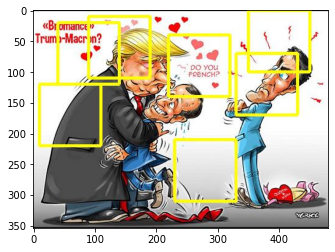

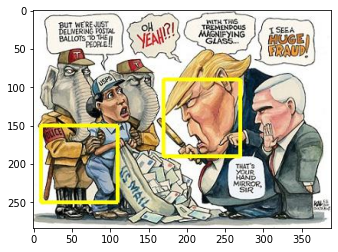

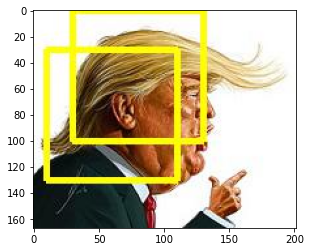

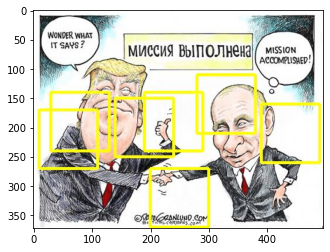

In [37]:
for img in os.listdir(result_img_path):
    image = cv2.imread(os.path.join(result_img_path, img))
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    plt.imshow(image)
    plt.show()
